In [38]:
import pandas as pd
import json
from globals import BASE_DIR
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from postprocess_baseline_top_k import dataset_metadata
from evaluation_metrics import ndcg, calculate_arp_poplift, evaluation_user_group_means, jensen_shannon, gini_index
import pingouin as pg

top_k_eval = 10

available_datasets = ["brightkite", "foursquaretky", "gowalla", "snowcard", "yelp"]

dataset = "snowcard"
valid_popularity = "item_pop"
recommendation_dirpart = "recommendations"

In [39]:
def process_top_k_json(input_file, output_file, k=10):
    """
    Process top-k recommendations from a JSON file, keeping only the item IDs for each user.

    Args:
    - input_file (str): Path to the original JSON file.
    - output_file (str): Path to save the processed JSON file.
    - k (int): Number of top-k recommendations to keep per user.
    """
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    
    try:
        with open(input_file, 'r') as infile:
            data = json.load(infile)

        top_k_result = {}
        for user_id, recommendations in data.items():
            if recommendations and isinstance(recommendations[0], dict):
                item_ids = recommendations[0]["item_id"][:k]
                top_k_result[user_id] = item_ids

        with open(output_file, 'w') as outfile:
            json.dump(top_k_result, outfile, indent=4)
        print(f"Processed file saved to: {output_file}")
    
    except Exception as e:
        print(f"Error processing {input_file}: {e}")

In [40]:
def create_model_directories(dataset, data, base_dir, recommendation_dirpart):
    model_directories = {}
    methods = ["baseline", "cp", "cp_min_js", "upd"]

    def recommender_dir_combiner(dataset, modelpart, method):
        return f"{base_dir}{dataset}_dataset/{recommendation_dirpart}/{modelpart}/{method + '/'}top_k_recommendations.json"

    for result in data:
        model_name = result["model"]
        model_directories[model_name] = {}
        
        for method in methods:
            model_directories[model_name][method] = recommender_dir_combiner(dataset, result["directory"], method)
    
    return model_directories

def sample_user_groups(user_groups, sample_size=100):
    sampled_groups = {}
    for group, ids in user_groups.items():
        if len(ids) >= sample_size:
            sampled_groups[group] = random.sample(ids, sample_size)
        else:
            print(f"Warning: Group '{group}' has less than {sample_size} users. Sampling all users.")
            sampled_groups[group] = ids
    return sampled_groups


def open_ground_truth_user_group(dataset, valid_popularity=valid_popularity):

    # Stays the same across all models 
    train_data = pd.read_csv(f"{BASE_DIR}{dataset}_dataset/processed_data_recbole/{dataset}_sample.train.inter", sep="\t")
    test_data = pd.read_csv(f"{BASE_DIR}{dataset}_dataset/processed_data_recbole/{dataset}_sample.test.inter", sep="\t")
    valid_data = pd.read_csv(f"{BASE_DIR}{dataset}_dataset/processed_data_recbole/{dataset}_sample.valid.inter", sep="\t")

    print("Train data, test data and valid data shapes:")
    print(train_data.shape, test_data.shape, valid_data.shape)
    #valid_data = pd.read_csv(f"{BASE_DIR}{dataset}_dataset/processed_data_recbole/{dataset}_sample.valid.inter", sep="\t") # originale struktur !!!
    train_data = pd.concat([train_data, valid_data])
    user_group_dir = f"{BASE_DIR}{dataset}_dataset/{dataset}_user_id_popularity.json"
    with open(user_group_dir) as f:
        user_groups = json.load(f)

    # checkin_df = pd.read_csv(
    #     f"{BASE_DIR}{dataset}_dataset/processed_data_recbole/{dataset}_sample.inter",
    #     sep="\t",
    # )

    checkin_df = train_data.copy()
    
    # Calculate item popularity
    value_counts = checkin_df["item_id:token"].value_counts().reset_index()
    value_counts.columns = ["item_id:token", "count"]
    value_counts[valid_popularity] = value_counts["count"] / len(value_counts)
    checkin_df = checkin_df.merge(
        value_counts[["item_id:token", valid_popularity]],
        on="item_id:token",
        how="left",
    )
    checkin_df.sort_values(by=valid_popularity, ascending=False, inplace=True)
    item_popularity = checkin_df.drop_duplicates(subset="item_id:token", keep="first")[
        ["item_id:token", valid_popularity]
    ]

    h_group = item_popularity.head(int(len(item_popularity) * 0.2))
    h_group["item_pop_group"] = "h"
    t_group = item_popularity.tail(int(len(item_popularity) * 0.2))
    t_group["item_pop_group"] = "t"
    m_group = item_popularity[
        ~item_popularity["item_id:token"].isin(h_group["item_id:token"]) &
        ~item_popularity["item_id:token"].isin(t_group["item_id:token"])
    ]
    m_group["item_pop_group"] = "m"

    item_popularity = pd.concat([h_group, m_group, t_group])
    item_popularity.sort_values(by=valid_popularity, inplace=True, ascending=False)




    upts = checkin_df.groupby("user_id:token")[valid_popularity].mean().reset_index()
    upts.columns = ["user_id:token", "upts"]
    return train_data, test_data, user_groups, item_popularity, upts


In [41]:
data = dataset_metadata(dataset, recommendation_dirpart)

In [42]:
model_dirs = create_model_directories(dataset, data, BASE_DIR, recommendation_dirpart)

In [43]:
def unstack_recommendations(df):
    # Repeat each user_id for the length of their item_id:token list
    unstacked_df = df.explode(["item_id:token"]).reset_index(drop=True)
    return unstacked_df

In [44]:
def top_k_to_df(recommender_dir, top_k_eval=top_k_eval):
    # Load the JSON data
    with open(recommender_dir) as f:
        data = json.load(f)

    # Initialize a list to store the recommendations
    base_recommendations = []

    # Iterate through the data and structure it for DataFrame
    for user, items in data.items():
        for item in items:
            base_recommendations.append({
                "user_id:token": user,
                "item_id:token": item
            })

    # Create a DataFrame from the structured recommendations
    base_df = pd.DataFrame(base_recommendations)

    # Assuming `unstack_recommendations` is a function you want to apply here:
    base_df = unstack_recommendations(base_df)

    df = base_df.groupby('user_id:token').head(top_k_eval)

    return df


In [45]:
train_data, test_data, user_groups, item_popularity, upts = open_ground_truth_user_group(dataset)
user_groups['all'] = user_groups['high'] + user_groups['medium'] + user_groups['low']

Train data, test data and valid data shapes:
(48895, 3) (15857, 3) (11583, 3)


/var/folders/9q/p0b6nwnd5071040x3849mdvc0000gn/T/ipykernel_1015/2055348030.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h_group["item_pop_group"] = "h"
/var/folders/9q/p0b6nwnd5071040x3849mdvc0000gn/T/ipykernel_1015/2055348030.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_group["item_pop_group"] = "t"
/var/folders/9q/p0b6nwnd5071040x3849mdvc0000gn/T/ipykernel_1015/2055348030.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [46]:
def create_pop_distributions(data):
    data = data.merge(item_popularity, on="item_id:token", how="left")
    g1 = data.loc[data["user_id:token"].isin(user_groups["high"])].value_counts("item_pop_group", normalize=True).rename("g1")
    g2 = data.loc[data["user_id:token"].isin(user_groups["medium"])].value_counts("item_pop_group", normalize=True).rename("g2")
    g3 = data.loc[data["user_id:token"].isin(user_groups["low"])].value_counts("item_pop_group", normalize=True).rename("g3")
    all = data.value_counts("item_pop_group", normalize=True).rename("all")
    distr_df = pd.DataFrame([g1, g2, g3, all]).fillna(0)
    #distr_df.rename(index={"high": "g1", "medium": "g2", "low": "g3"}, inplace=True)
    return distr_df


ground_truth_distr = create_pop_distributions(train_data)

In [47]:
ground_truth_distr

item_pop_group,h,m,t
g1,0.923670,0.075837,0.000492
g2,0.678026,0.316103,0.005871
g3,0.045670,0.914176,0.040153
all,0.634545,0.356427,0.009028


In [48]:
def preprocess_distr(distr_df):
    distr_df.rename(index={"g1":"high", "g2":"medium", "g3":"low"}, inplace=True) # COMMENT IN FOR CALCULATING RESULTS, COMMENT OUT FOR PLOTTING
    data = distr_df.to_dict()
    result = []
    # Get user groups from any one of the nested dictionaries
    user_groups = data['h'].keys()

    for group in user_groups:
        # Extract h, m, t values for the current user group
        h_value = data.get('h', {}).get(group, 0)
        m_value = data.get('m', {}).get(group, 0)
        t_value = data.get('t', {}).get(group, 0)
        
        result.append({
            'user_group': group,
            'h_ratio': h_value,
            'm_ratio': m_value,
            't_ratio': t_value
        })

    return result


In [49]:
distr_dict_ground_truth = preprocess_distr(ground_truth_distr)


In [50]:
jsd_group = {}
for group_gt, group_recs in zip(distr_dict_ground_truth, distr_dict_ground_truth):
    jsd_group[group_gt['user_group']] = jensen_shannon(group_gt, group_recs)


In [51]:
jsd_group

{'high': 0.0, 'medium': 0.0, 'low': 0.0, 'all': 0.0}

In [52]:
ground_truth_distr

item_pop_group,h,m,t
high,0.923670,0.075837,0.000492
medium,0.678026,0.316103,0.005871
low,0.045670,0.914176,0.040153
all,0.634545,0.356427,0.009028


In [53]:
# Function for plotting popularity distribution (no legend inside this function)
def plot_popularity_distribution(ax, distr_df, label):
    colors = plt.cm.viridis([0.1, 0.5, 0.9])
    bars = distr_df.plot(kind='bar', stacked=True, ax=ax, color=colors, legend=False, edgecolor='black', linewidth=0, width=0.8)
    ax.set_title(f"{label}", fontsize=10)
    ax.set_xlabel("User Groups")
    ax.set_ylabel("Item Pop Ratio")
    return distr_df

def plot_line_chart(results, model_name, ax, metric, title):
    """
    Plot scores (nDCG, ARP, PopLift) as line plots for each user group, comparing methods.
    """
    methods = ["baseline", "cp", "cp_min_js", "upd"]
    user_groups = ["high", "medium", "low", "all"]
    group_labels = ["High", "Medium", "Low", "All"]

    # Extract metric scores for each method and user group
    metric_values = {
        method: [results[model_name][method][group][f"{metric}"] for group in user_groups]
        for method in methods
    }

    # Transpose values to plot lines for user groups
    metric_transposed = list(zip(*metric_values.values()))  # Group-wise scores across methods

    # Plot each user group's metric scores as a line plot
    colors = plt.cm.viridis([0.1, 0.5, 0.9, 0.3])
    for idx, group_label in enumerate(group_labels):
        ax.plot(methods, metric_transposed[idx], marker='o', label=group_label, color=colors[idx])

    # Set x-axis and y-axis labels and grid
    ax.set_ylabel(f"{metric.upper()} Score", fontsize=12)
    ax.grid(True)

    # Increase the font size of the x-axis tick labels (methods)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)




In [54]:
df = top_k_to_df("/Volumes/Forster Neu/Masterarbeit Data/brightkite_dataset/recommendations/brightkite_sample-SimpleX-Jan-22-2025_15-12-28/cp/top_k_recommendations.json")

In [55]:
flattened_item_ids = df["item_id:token"].values.tolist()
num_items = df["item_id:token"].nunique()
gini_index(flattened_item_ids, num_items)


0.6312240638428488

In [56]:
# df = top_k_to_df('/Volumes/Forster Neu/Masterarbeit Data/yelp_dataset/recommendations/yelp_sample-BPR-Jan-22-2025_15-15-41/baseline/top_k_recommendations.json')
# ndcg_scores = ndcg(df, test_data, top_k_eval)
# df_with_item_pop = df.merge(item_popularity, on="item_id:token", how="left")
# arp_scores, poplift_scores = calculate_arp_poplift(df_with_item_pop, item_popularity, upts, valid_popularity)
# group_eval,group_ndcg_scores, group_arp_scores, group_poplift_scores  = evaluation_user_group_means(ndcg_scores, arp_scores, poplift_scores, user_groups, df)



# ttest_results = {}
# ttest_results["ndcg"] = calculate_t_test(group_ndcg_scores)
# ttest_results["arp"] = calculate_t_test(group_arp_scores)
# ttest_results["poplift"] = calculate_t_test(group_poplift_scores)

In [57]:
def calculate_t_test(group_scores):
    """Source t-test: https://www.geeksforgeeks.org/how-to-conduct-a-two-sample-t-test-in-python/"""
    
    ttest = {}
    # Conducting two-sample ttest
    result_low_high = pg.ttest(list(group_scores["low"].values()), 
                    list(group_scores["high"].values()),
                    correction=True)
    
    result_low_med = pg.ttest(list(group_scores["low"].values()), 
                    list(group_scores["medium"].values()),
                    correction=True)
    
    ttest["low_high"] = float(result_low_high["p-val"])
    ttest["low_medium"] = float(result_low_med["p-val"])

    return ttest


In [58]:
model_dirs

{'BPR': {'baseline': '/Volumes/Forster Neu/Masterarbeit Data/snowcard_dataset/recommendations/snowcard_sample-BPR-Jan-22-2025_15-13-47/baseline/top_k_recommendations.json',
  'cp': '/Volumes/Forster Neu/Masterarbeit Data/snowcard_dataset/recommendations/snowcard_sample-BPR-Jan-22-2025_15-13-47/cp/top_k_recommendations.json',
  'cp_min_js': '/Volumes/Forster Neu/Masterarbeit Data/snowcard_dataset/recommendations/snowcard_sample-BPR-Jan-22-2025_15-13-47/cp_min_js/top_k_recommendations.json',
  'upd': '/Volumes/Forster Neu/Masterarbeit Data/snowcard_dataset/recommendations/snowcard_sample-BPR-Jan-22-2025_15-13-47/upd/top_k_recommendations.json'},
 'LORE': {'baseline': '/Volumes/Forster Neu/Masterarbeit Data/snowcard_dataset/recommendations/snowcard_sample-contextpoi-LORE-Jan-22-2025_09-00-00/baseline/top_k_recommendations.json',
  'cp': '/Volumes/Forster Neu/Masterarbeit Data/snowcard_dataset/recommendations/snowcard_sample-contextpoi-LORE-Jan-22-2025_09-00-00/cp/top_k_recommendations.jso

/var/folders/9q/p0b6nwnd5071040x3849mdvc0000gn/T/ipykernel_1015/3823209497.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ttest["low_high"] = float(result_low_high["p-val"])
/var/folders/9q/p0b6nwnd5071040x3849mdvc0000gn/T/ipykernel_1015/3823209497.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ttest["low_medium"] = float(result_low_med["p-val"])
/var/folders/9q/p0b6nwnd5071040x3849mdvc0000gn/T/ipykernel_1015/3823209497.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ttest["low_high"] = float(result_low_high["p-val"])
/var/folders/9q/p0b6nwnd5071040x3849mdvc0000gn/T/ipykernel_1015/3823209497.py:15: FutureWarning: Calling float on a single element Series is deprecated and will r

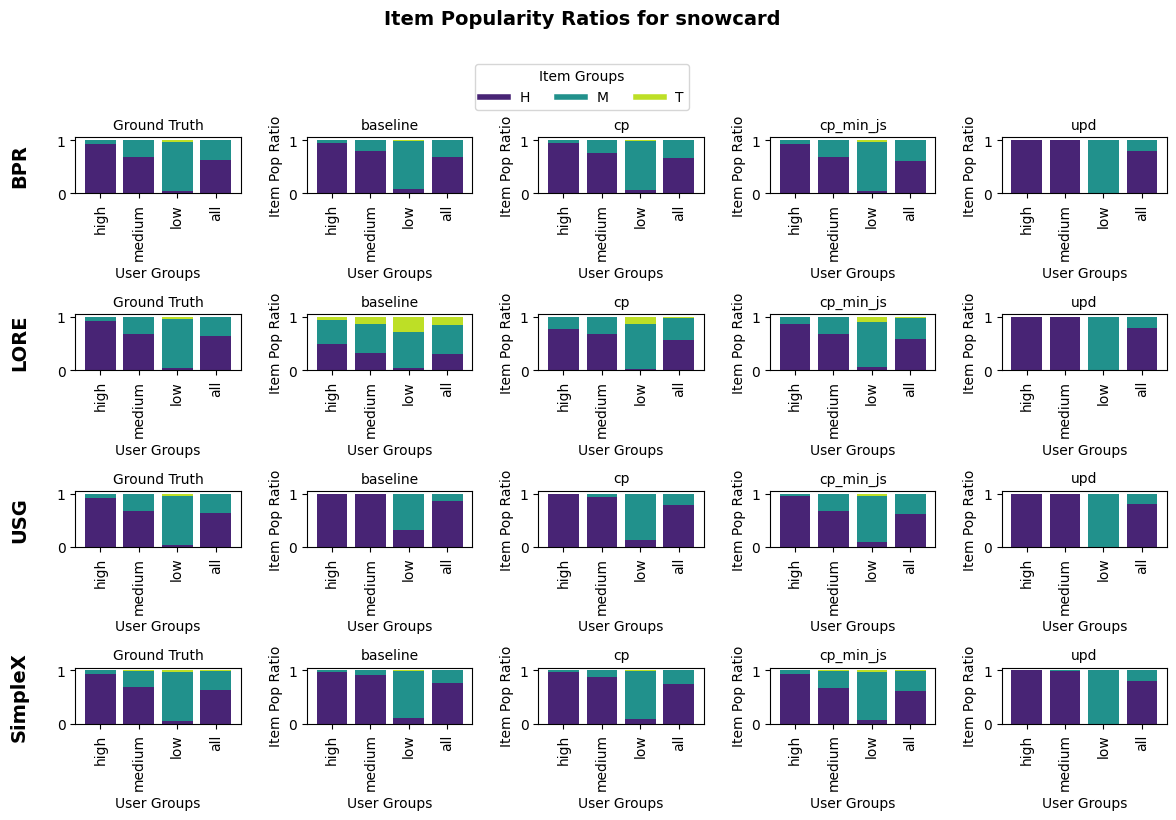

In [59]:


results = {}
ttest_results = {}
fig, axs = plt.subplots(len(model_dirs), 5, figsize=(12, 12))  # Adjusted for nDCG plots

for i, (model_name, methods) in enumerate(model_dirs.items()):
    results[model_name] = {}
    ttest_results[model_name] = {}

    # Plot the ground truth in the first column
    ax = axs[i, 0]
    plot_popularity_distribution(ax, ground_truth_distr, "Ground Truth")

    for j, (method_name, json_file) in enumerate(methods.items()):

        ttest_results[model_name][method_name] = {}
        # with open(json_file, 'r') as f:
        #     eval_data = json.load(f)

        df = top_k_to_df(json_file)
        ndcg_scores = ndcg(df, test_data, top_k_eval)
        df_with_item_pop = df.merge(item_popularity, on="item_id:token", how="left")
        arp_scores, poplift_scores = calculate_arp_poplift(df_with_item_pop, item_popularity, upts, valid_popularity)
        distr_df = create_pop_distributions(df)
        distr_dict_recs = preprocess_distr(distr_df)


        jsd_group = {}
        for group_gt, group_recs in zip(distr_dict_ground_truth, distr_dict_recs):
            jsd_group[group_gt['user_group']] = jensen_shannon(group_gt, group_recs)

        group_eval, group_ndcg_scores, group_arp_scores, group_poplift_scores = evaluation_user_group_means(ndcg_scores, arp_scores, poplift_scores, user_groups, df)
        ttest_results[model_name][method_name]["ndcg"] = calculate_t_test(group_ndcg_scores)
        ttest_results[model_name][method_name]["arp"] = calculate_t_test(group_arp_scores)
        ttest_results[model_name][method_name]["poplift"] = calculate_t_test(group_poplift_scores)
    
        for group_name, jsd_value in jsd_group.items():
            if group_name in group_eval:
                group_eval[group_name]["js"] = jsd_value
            else:
                # In case the group exists in jsd_group but not in group_eval
                group_eval[group_name] = {"js": jsd_value}

        results[model_name][method_name] = group_eval
    
        

        ax = axs[i, j + 1]
        plot_popularity_distribution(ax, distr_df, method_name)

    axs[i, 0].set_ylabel(model_name, fontsize=14, weight='bold', labelpad=20)

fig.suptitle(f"Item Popularity Ratios for {dataset}", fontsize=14, weight='bold')
plt.tight_layout(rect=[0, 0.3, 1, 0.93])  # Reduced space between title and legend

handles = [plt.Line2D([0], [0], color=color, lw=4) for color in plt.cm.viridis([0.1, 0.5, 0.9])]
labels = ["H", "M", "T"]
fig.legend(handles, labels, title="Item Groups", loc='upper center', bbox_to_anchor=(0.5, 0.94), ncol=3)

#plt.savefig(f"{BASE_DIR}{dataset}_dataset/plots/{dataset}_popularity_distribution.png")

In [60]:
def plot_metric(results, metric, dataset):
    n_models = len(results)
    n_cols = 4
    n_rows = math.ceil(n_models / n_cols)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
    axs = axs.flatten()  # Flatten to simplify indexing

    for i, (model_name, methods) in enumerate(results.items()):
        plot_line_chart(results, model_name, axs[i], metric, f"{metric.upper()} Scores")
        axs[i].set_ylabel(model_name, fontsize=14, weight='bold')

    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])  # Remove unused subplots

    fig.suptitle(f"{metric.upper()} Comparison for {dataset}", fontsize=18, weight='bold')

    ndcg_handles = [plt.Line2D([0], [0], color=color, lw=2, marker='o') for color in plt.cm.viridis([0.2, 0.6, 0.8, 0.3])]
    ndcg_labels = ["g1", "g2", "g3", "all"]
    fig.legend(ndcg_handles, ndcg_labels, title="User Groups", loc='upper center', bbox_to_anchor=(0.5, 0.92), ncol=4)

    plt.tight_layout(rect=[0, 0.02, 1, 0.88])  # Reduced bottom space
    plt.savefig(f"{BASE_DIR}{dataset}_dataset/plots/{dataset}_{metric}_comparison.png")






In [61]:
# results = {}

# for model_name, methods in model_dirs.items():
#     results[model_name] = {}

#     for method_name, json_file in methods.items():
#         df = top_k_to_df(json_file)
#         ndcg_scores = ndcg(df, test_data, top_k_eval)
#         df_with_item_pop = df.merge(item_popularity, on="item_id:token", how="left")
#         arp_scores, poplift_scores = calculate_arp_poplift(df_with_item_pop, item_popularity, upts, valid_popularity)
#         distr_df = create_pop_distributions(df)
#         distr_dict_recs = preprocess_distr(distr_df)

#         jsd_group = {group_gt['user_group']: jensen_shannon(group_gt, group_recs)
#                         for group_gt, group_recs in zip(distr_dict_ground_truth, distr_dict_recs)}

#         group_eval = evaluation_user_group_means(ndcg_scores, arp_scores, poplift_scores, user_groups)

#         for group_name, jsd_value in jsd_group.items():
#             group_eval.setdefault(group_name, {})['js_mean'] = jsd_value

#         results[model_name][method_name] = group_eval

In [62]:
results

{'BPR': {'baseline': {'high': {'ndcg': 0.24096525951085088,
    'arp': 0.455659320477502,
    'poplift': -0.07087782093759169,
    'gini': 0.6570522088353414,
    'js': 0.0020801323385443286},
   'medium': {'ndcg': 0.11279244870306722,
    'arp': 0.34878971533516956,
    'poplift': 0.15019334501234113,
    'gini': 0.5647722529158996,
    'js': 0.014522240487271819},
   'low': {'ndcg': 0.21022282313127566,
    'arp': 0.10451469237832876,
    'poplift': 0.12886571382401604,
    'gini': 0.5527192982456146,
    'js': 0.007694807667274203},
   'all': {'ndcg': 0.15791308575026675,
    'arp': 0.32130863177226837,
    'poplift': 0.10171358558468947,
    'gini': 0.5921663492063489,
    'js': 0.002620938867380853}},
  'cp': {'high': {'ndcg': 0.24096525951085088,
    'arp': 0.455659320477502,
    'poplift': -0.07087782093759169,
    'gini': 0.6570522088353414,
    'js': 0.0020801323385443286},
   'medium': {'ndcg': 0.11275897291758852,
    'arp': 0.33972161003979157,
    'poplift': 0.122296839885

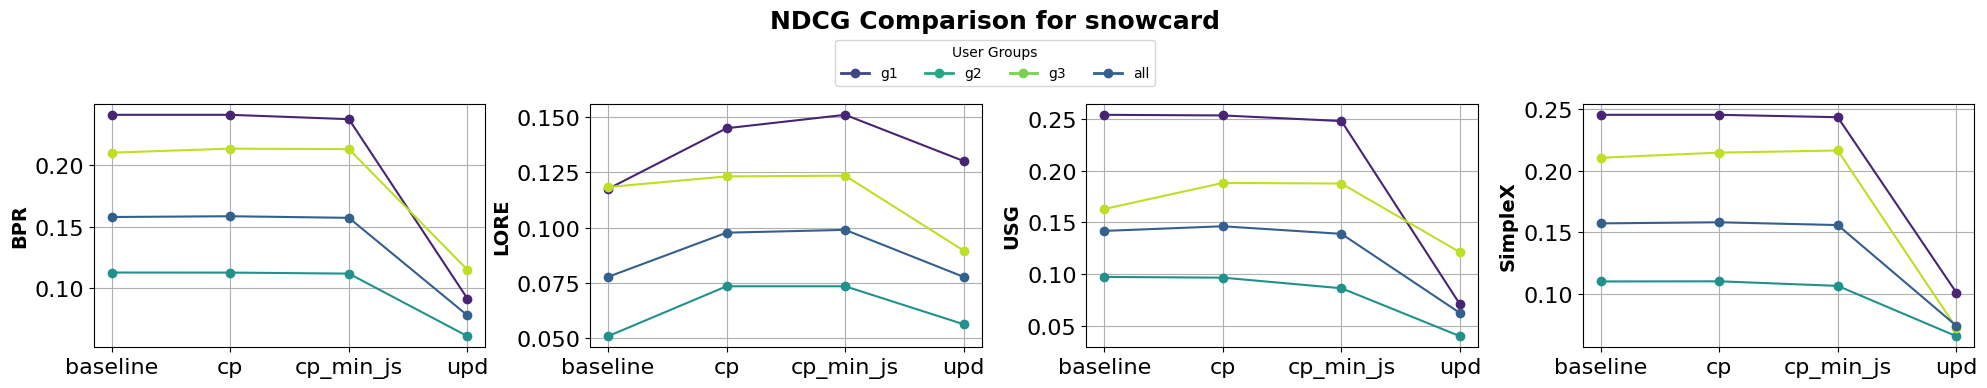

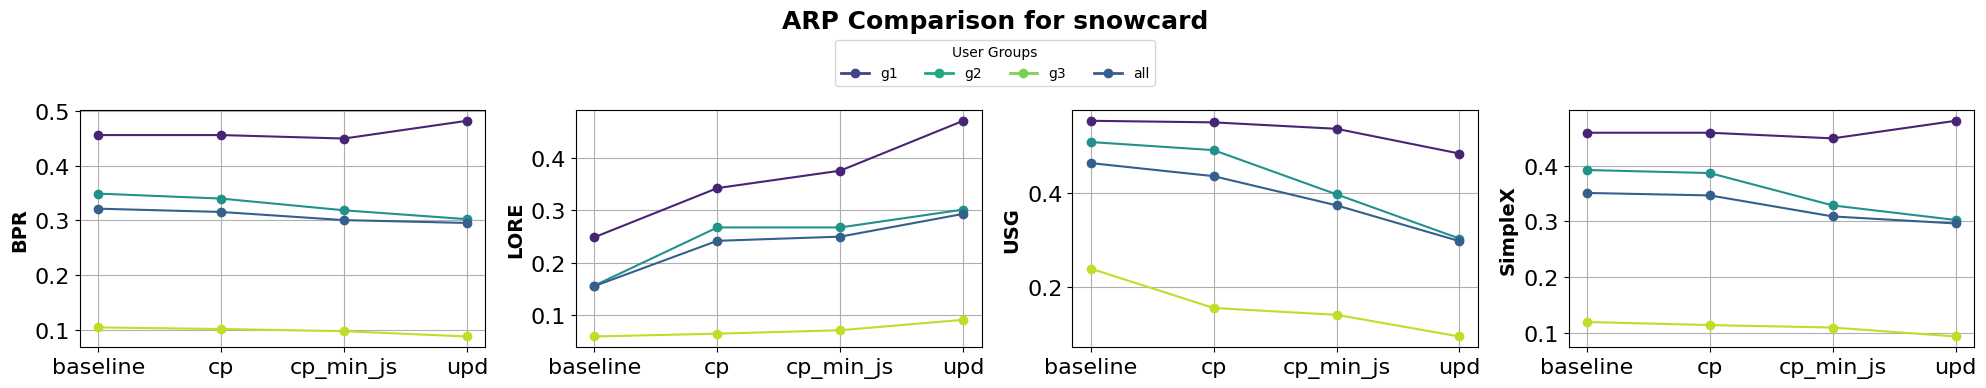

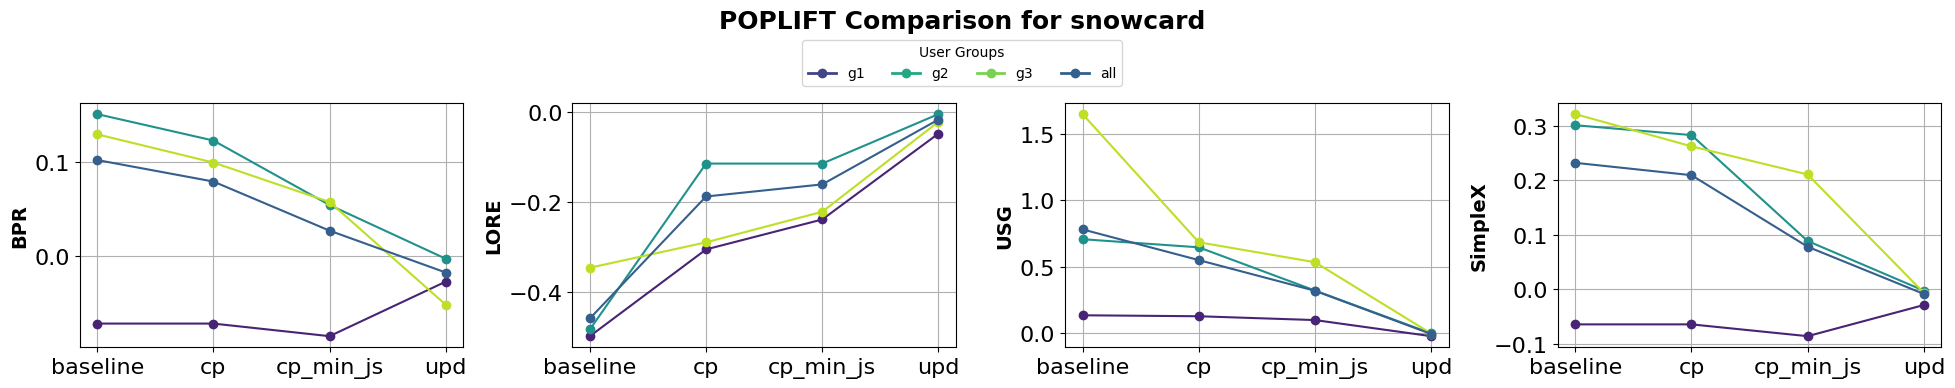

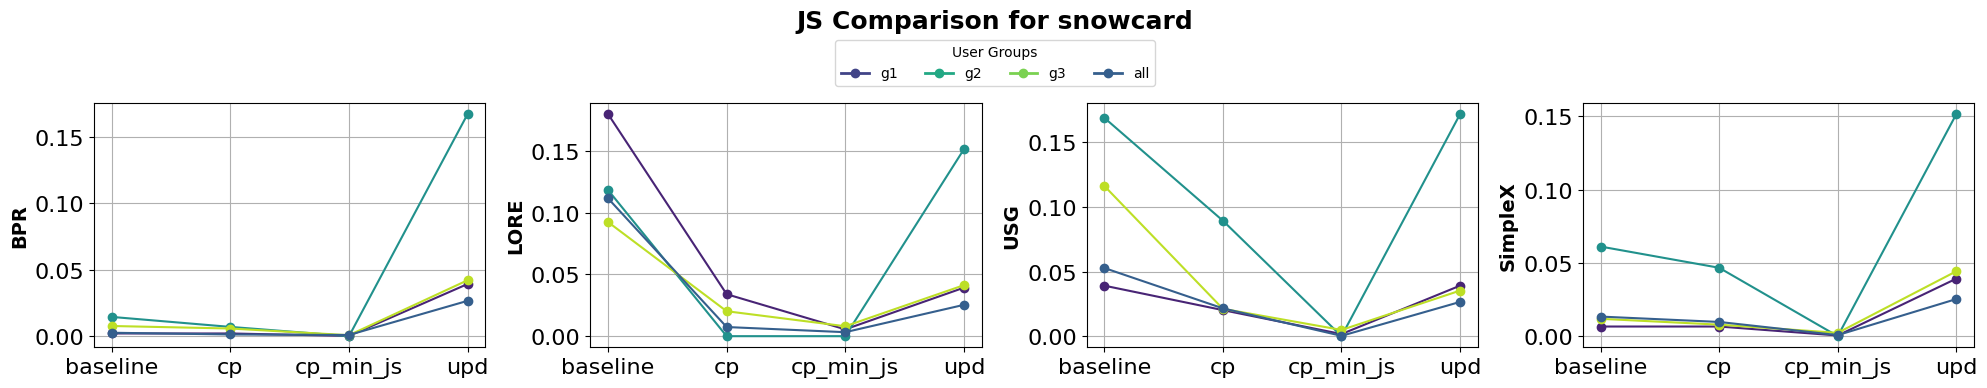

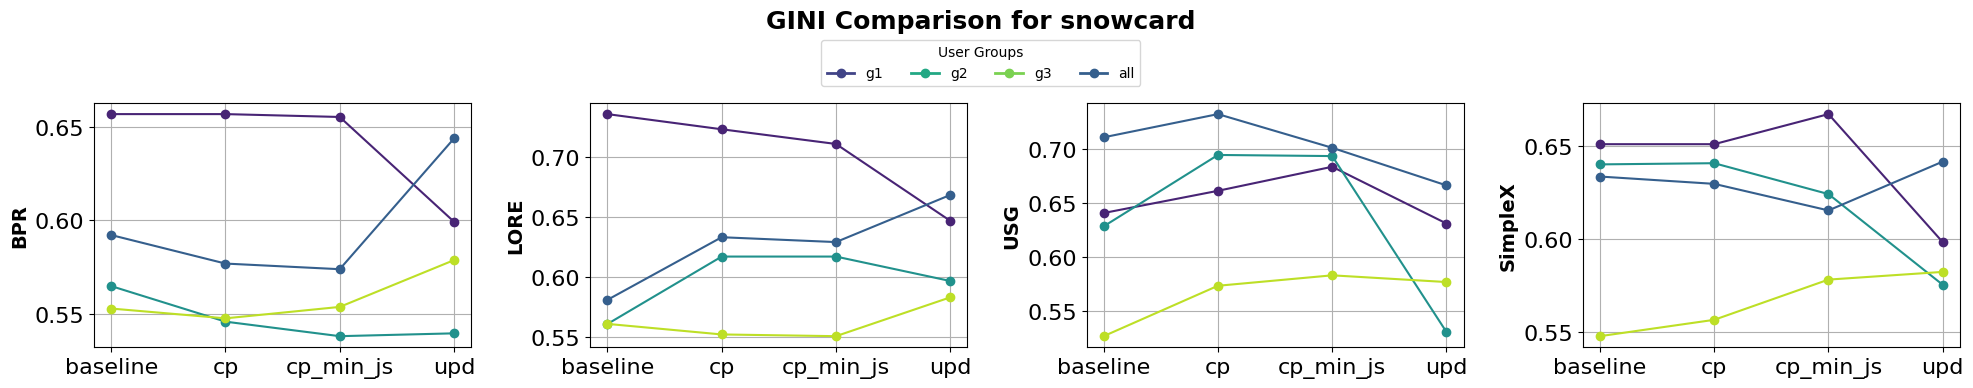

In [63]:

#plot_popularity_distributions(model_dirs, ground_truth_distr, dataset)
plot_metric(results, "ndcg", dataset)
plot_metric(results, "arp", dataset)
plot_metric(results, "poplift", dataset)
plot_metric(results, "js", dataset)
plot_metric(results, "gini", dataset)

In [64]:
# Collect results into rows for CSV output
rows = []
for model_name, methods in ttest_results.items():
    for method_name, metrics in methods.items():
        for metric_name, metric_eval in metrics.items():
            for group_comparison, group_pvalue in metric_eval.items():
                print(metric_name)
                print(metric_eval)
                print(group_pvalue)
           
                row = {
                    'dataset': dataset,
                    'model': model_name,
                    'method': method_name,
                    'user_group': group_comparison,
                    'ndcg': metrics["ndcg"],
                    'arp': metrics['arp'],
                    'poplift': metrics['poplift'],
        
                    
                }
                rows.append(row)

    # Create a DataFrame from the rows
    df_ttest_results = pd.DataFrame(rows)

# Save the evaluation results to a CSV file
#df_ttest_results.to_csv(f'{BASE_DIR}/{dataset}_dataset/evaluation_results_ttest.csv', index=False)
# print("Evaluation results have been saved to 'evaluation_results.csv'")

ndcg
{'low_high': 0.07521279084211573, 'low_medium': 2.7562811342215487e-12}
0.07521279084211573
ndcg
{'low_high': 0.07521279084211573, 'low_medium': 2.7562811342215487e-12}
2.7562811342215487e-12
arp
{'low_high': 1.624739155305104e-216, 'low_medium': 3.580829359174282e-238}
1.624739155305104e-216
arp
{'low_high': 1.624739155305104e-216, 'low_medium': 3.580829359174282e-238}
3.580829359174282e-238
poplift
{'low_high': 5.931140285765203e-07, 'low_medium': 0.5795213325584657}
5.931140285765203e-07
poplift
{'low_high': 5.931140285765203e-07, 'low_medium': 0.5795213325584657}
0.5795213325584657
ndcg
{'low_high': 0.1112066445202917, 'low_medium': 4.848884054711264e-13}
0.1112066445202917
ndcg
{'low_high': 0.1112066445202917, 'low_medium': 4.848884054711264e-13}
4.848884054711264e-13
arp
{'low_high': 7.28875310954751e-216, 'low_medium': 3.697736374604728e-274}
7.28875310954751e-216
arp
{'low_high': 7.28875310954751e-216, 'low_medium': 3.697736374604728e-274}
3.697736374604728e-274
poplift
{'

In [65]:
# Write to JSON file
json_file = f'{BASE_DIR}/{dataset}_dataset/evaluation_results_ttest.json'
with open(json_file, "w") as f:
    json.dump(ttest_results, f, indent=4)


In [66]:
df_ttest_results

,dataset,model,method,user_group,ndcg,arp,poplift
0,snowcard,BPR,baseline,low_high,"{'low_high': 0.07521279084211573, 'low_medium'...","{'low_high': 1.624739155305104e-216, 'low_medi...","{'low_high': 5.931140285765203e-07, 'low_mediu..."
1,snowcard,BPR,baseline,low_medium,"{'low_high': 0.07521279084211573, 'low_medium'...","{'low_high': 1.624739155305104e-216, 'low_medi...","{'low_high': 5.931140285765203e-07, 'low_mediu..."
2,snowcard,BPR,baseline,low_high,"{'low_high': 0.07521279084211573, 'low_medium'...","{'low_high': 1.624739155305104e-216, 'low_medi...","{'low_high': 5.931140285765203e-07, 'low_mediu..."
3,snowcard,BPR,baseline,low_medium,"{'low_high': 0.07521279084211573, 'low_medium'...","{'low_high': 1.624739155305104e-216, 'low_medi...","{'low_high': 5.931140285765203e-07, 'low_mediu..."
4,snowcard,BPR,baseline,low_high,"{'low_high': 0.07521279084211573, 'low_medium'...","{'low_high': 1.624739155305104e-216, 'low_medi...","{'low_high': 5.931140285765203e-07, 'low_mediu..."
...,...,...,...,...,...,...,...
91,snowcard,SimpleX,upd,low_medium,"{'low_high': 0.0036679074871368666, 'low_mediu...","{'low_high': 0.0, 'low_medium': 0.0}","{'low_high': 1.6768333485044844e-19, 'low_medi..."
92,snowcard,SimpleX,upd,low_high,"{'low_high': 0.0036679074871368666, 'low_mediu...","{'low_high': 0.0, 'low_medium': 0.0}","{'low_high': 1.6768333485044844e-19, 'low_medi..."
93,snowcard,SimpleX,upd,low_medium,"{'low_high': 0.0036679074871368666, 'low_mediu...","{'low_high': 0.0, 'low_medium': 0.0}","{'low_high': 1.6768333485044844e-19, 'low_medi..."
94,snowcard,SimpleX,upd,low_high,"{'low_high': 0.0036679074871368666, 'low_mediu...","{'low_high': 0.0, 'low_medium': 0.0}","{'low_high': 1.6768333485044844e-19, 'low_medi..."


In [67]:
# Collect results into rows for CSV output
rows = []
for model_name, methods in results.items():
    for method_name, group_eval in methods.items():
        for group_name, metrics in group_eval.items():
            row = {
                'dataset': dataset,
                'model': model_name,
                'method': method_name,
                'user_group': group_name,
                'ndcg': metrics['ndcg'],
                'arp': metrics['arp'],
                'poplift': metrics['poplift'],
                'js': metrics['js'],
                'gini': metrics['gini'],
                
            }
            rows.append(row)

# Create a DataFrame from the rows
df_results = pd.DataFrame(rows)

# Save the evaluation results to a CSV file
df_results.to_csv(f'{BASE_DIR}/{dataset}_dataset/evaluation_results.csv', index=False)
# print("Evaluation results have been saved to 'evaluation_results.csv'")

In [68]:
df_results.head(50)

,dataset,model,method,user_group,ndcg,arp,poplift,js,gini
0,snowcard,BPR,baseline,high,0.240965,0.455659,-0.070878,0.002080,0.657052
1,snowcard,BPR,baseline,medium,0.112792,0.348790,0.150193,0.014522,0.564772
2,snowcard,BPR,baseline,low,0.210223,0.104515,0.128866,0.007695,0.552719
3,snowcard,BPR,baseline,all,0.157913,0.321309,0.101714,0.002621,0.592166
4,snowcard,BPR,cp,high,0.240965,0.455659,-0.070878,0.002080,0.657052
5,snowcard,BPR,cp,medium,0.112759,0.339722,0.122297,0.007014,0.545689
6,snowcard,BPR,cp,low,0.213465,0.101664,0.099089,0.005804,0.547463
7,snowcard,BPR,cp,all,0.158542,0.315298,0.079020,0.001324,0.576853
8,snowcard,BPR,cp_min_js,high,0.237421,0.449318,-0.084175,0.000246,0.655514
9,snowcard,BPR,cp_min_js,medium,0.111904,0.318334,0.054205,0.000045,0.537893


In [69]:

# 1. Best nDCG for each model and user group
best_ndcg_per_model_group = df_results.loc[df_results.groupby(['model', 'user_group'])['ndcg'].idxmax()]

# 2. Best overall nDCG for each user group
best_overall_ndcg_per_group = df_results.loc[df_results.groupby(['user_group'])['ndcg'].idxmax()]

# Display or save the results
print("Best nDCG for each model and user group:")
print(best_ndcg_per_model_group)

print("\nBest overall nDCG for each user group:")
print(best_overall_ndcg_per_group)


best_ndcg_per_model_group.to_csv(f'{BASE_DIR}/{dataset}_dataset/best_ndcg_per_model_group.csv', index=False)
best_overall_ndcg_per_group.to_csv(f'{BASE_DIR}/{dataset}_dataset/best_overall_ndcg_per_group.csv', index=False)

Best nDCG for each model and user group:
     dataset    model     method user_group      ndcg       arp   poplift  \
7   snowcard      BPR         cp        all  0.158542  0.315298  0.079020   
0   snowcard      BPR   baseline       high  0.240965  0.455659 -0.070878   
6   snowcard      BPR         cp        low  0.213465  0.101664  0.099089   
1   snowcard      BPR   baseline     medium  0.112792  0.348790  0.150193   
27  snowcard     LORE  cp_min_js        all  0.098950  0.249662 -0.161301   
24  snowcard     LORE  cp_min_js       high  0.150923  0.375420 -0.239173   
26  snowcard     LORE  cp_min_js        low  0.123424  0.071247 -0.222073   
21  snowcard     LORE         cp     medium  0.073468  0.267214 -0.115086   
55  snowcard  SimpleX         cp        all  0.158222  0.346467  0.209243   
48  snowcard  SimpleX   baseline       high  0.245658  0.459105 -0.063909   
58  snowcard  SimpleX  cp_min_js        low  0.216625  0.108983  0.210537   
53  snowcard  SimpleX         cp   